In [1]:
import csv
import random
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Defining some useful global variables
Next you will define some global variables that will be used throughout the assignment.

EMBEDDING_DIM: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 100.

MAXLEN: Maximum length of all sequences. Defaults to 16.

TRUNCATING: Truncating strategy (truncate either before or after each sequence.). Defaults to 'post'.

PADDING: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.

OOV_TOKEN: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "<OOV>".

MAX_EXAMPLES: Max number of examples to use. Defaults to 160000 (10% of the original number of examples)

TRAINING_SPLIT: Proportion of data used for training. Defaults to 0.9

For now leave them unchanged but after submitting your assignment for grading you are encouraged to come back here and play with these parameters to see the impact they have in the classification process.

In [2]:
EMBEDDING_DIM=100
MAXLEN=16
TRUNCATING="post"
PADDING="post"
OOV_TOKEN="<OOV>"
MAX_EXAMPLES=160000
TRAINING_SPLIT=0.9

# Explore the dataset
The dataset is provided in a csv file.

Each row of this file contains the following values separated by commas:

target: the polarity of the tweet (0 = negative, 4 = positive)

ids: The id of the tweet

date: the date of the tweet

flag: The query. If there is no query, then this value is NO_QUERY.

user: the user that tweeted

text: the text of the tweet

Take a look at the first two examples:

In [5]:
SENTIMENT_CSV="/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv"
with open(SENTIMENT_CSV,'r') as f:
    print(f"First data point looks like this:\n\n{f.readline()}")
    print(f"Second data point looks like this:\n\n{f.readline()}")

First data point looks like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Second data point looks like this:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



# Parsing the raw data
Now you need to read the data from the csv file. To do so, complete the parse_data_from_file function.

A couple of things to note:

You should NOT omit the first line as the file does not contain headers.

There is no need to save the data points as numpy arrays, regular lists is fine.

To read from csv files use csv.reader by passing the appropriate arguments.
csv.reader returns an iterable that returns each row in every iteration. So the label can be accessed via row[0] and the text via row[5].

The labels are originally encoded as strings ('0' representing negative and '4' representing positive). You need to change this so that the labels are integers and 0 is used for representing negative, while 1 should represent positive.

In [27]:
import pandas as pd
df=pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',
               encoding="latin",header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [31]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

,sentiment,id,date,query,user_id,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [32]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [44]:
labels=df.sentiment.values.tolist()
for i in range(len(labels)):
    if labels[i]==4 or labels[i]==2:
        labels[i]=1
sentences=df.text.values.tolist()

In [46]:


print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[1]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 1600000 examples

Text of second example should look like this:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

Text of fourth example should look like this:
my whole body feels itchy and like its on fire 

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


You might have noticed that this dataset contains a lot of examples. In order to keep a low execution time of this assignment you will be using only 10% of the original data. The next cell does this while also randomnizing the datapoints that will be used:

In [47]:
# Bundle the two lists into a single one
sentences_and_labels=list(zip(sentences,labels))

# Perform random sampling
random_seed=42
sentences_and_labels=random.sample(sentences_and_labels,MAX_EXAMPLES)

# Unpack back into separate lists
sentences,labels=zip(*sentences_and_labels)

print(f"There are {len(sentences)} sentences and {len(labels)} labels after random sampling\n")

There are 160000 sentences and 160000 labels after random sampling



In [48]:
def train_val_split(sentences, labels, training_split):
    
    ### START CODE HERE
    
    # Compute the number of sentences that will be used for training (should be an integer)
    train_size=int(len(sentences)*training_split)

    # Split the sentences and labels into train/validation splits
    
    train_sentences=sentences[0:train_size]
    validation_sentences=sentences[train_size: ]
    
    train_labels=labels[0:train_size]
    validation_labels=labels[train_size:]
    
    
    ### END CODE HERE
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [49]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 144000 sentences for training.

There are 144000 labels for training.

There are 16000 sentences for validation.

There are 16000 labels for validation.


# Tokenization - Sequences, truncating and padding
Now that you have sets for training and validation it is time for you to begin the tokenization process.

Begin by completing the fit_tokenizer function below. This function should return a Tokenizer that has been fitted to the training sentences.

In [50]:
def fit_tokenizer(train_sentences,oov_token):
    
    tokenizer=Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(train_sentences)
    
    return tokenizer

In [51]:
tokenizer=fit_tokenizer(train_sentences,OOV_TOKEN)

word_index=tokenizer.word_index
VOCAB_SIZE=len(word_index)
print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'i' should be {word_index['i']}")

Vocabulary contains 128439 words

<OOV> token included in vocabulary

index of word 'i' should be 2


In [52]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    
    sequences=tokenizer.texts_to_sequences(sentences)
    pad_trunc_sequences=pad_sequences(sequences,maxlen=maxlen,padding=padding,
                                     truncating=truncating)
    
    
    
    return pad_trunc_sequences

In [53]:
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (144000, 16)

Padded and truncated validation sequences have shape: (16000, 16)


Remember that the pad_sequences function returns numpy arrays, so your training and validation sequences are already in this format.

However the labels are still Python lists. Before going forward you should convert them numpy arrays as well. You can do this by running the following cell:

In [55]:
train_labels=np.array(train_labels)
val_labels=np.array(val_labels)

# Using pre-defined Embeddings
This time you will not be learning embeddings from your data but you will be using pre-trained word vectors.

In particular you will be using the 100 dimension version of [GloVe ](https://nlp.stanford.edu/projects/glove/)from Stanford.

In [58]:
GLOVE_FILE="/kaggle/input/glove6b100dtxt/glove.6B.100d.txt"

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS={}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values=line.split()
        word=values[0]
        coefs=np.asarray(values[1:],dtype='float32')
        GLOVE_EMBEDDINGS[word]=coefs

Now you have access to GloVe's pre-trained word vectors. Isn't that cool?

Let's take a look at the vector for the word dog:

In [60]:
test_word = 'flower'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word flower looks like this:

[-3.8032e-01  1.5292e+00 -9.4527e-01 -1.3887e-03  5.5101e-01  4.8126e-01
 -1.2502e-01  3.8229e-01 -7.9148e-01 -6.3399e-01 -1.0941e+00 -1.6552e-01
  5.9088e-01  5.0750e-01  5.2301e-01  4.2854e-01  2.7123e-01  5.0605e-01
  6.1477e-01 -2.6955e-01 -6.3666e-01 -2.3305e-01  3.3131e-01 -1.3382e-01
  1.1594e+00  1.4189e+00  4.1742e-01 -4.4100e-01 -1.1032e-01  1.1094e-02
 -6.1099e-01 -3.6861e-01  1.4686e+00 -1.5860e-01 -3.8299e-01  5.8125e-01
 -1.3489e-02 -1.0072e-02 -3.1125e-01 -8.7364e-01  3.4630e-01 -4.5256e-01
  1.7114e-01 -3.9858e-01  1.0024e+00  1.2011e-01 -3.9076e-01  2.6316e-01
 -3.6461e-02 -1.0930e-01 -1.8831e-01 -7.0645e-01  1.9801e-01  4.5763e-01
 -2.3255e-01 -8.2976e-01 -1.2711e+00  5.6615e-01  1.0101e+00  3.0987e-01
  1.8205e-01  6.0414e-01 -4.3705e-01  9.5937e-01  4.3737e-01 -1.7839e-01
  8.1172e-01 -1.5144e-01 -1.3604e-01 -5.9853e-01 -1.8106e-01  1.2243e-01
 -4.9549e-01 -9.0807e-01  5.2064e-01  1.5329e-01 -1.1036e-01  1.0470e

In [61]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


In [62]:
len(GLOVE_EMBEDDINGS)

400000

# Represent the words in your vocabulary using the embeddings
Save the vector representation of each word in the vocabulary in a numpy array.

A couple of things to notice:

If a word in your vocabulary is not present in GLOVE_EMBEDDINGS the representation for that word is left as a column of zeros.

word_index starts counting at 1, because of this you will need to add an extra column at the left-most side of the EMBEDDINGS_MATRIX array. This is the reason why you add 1 to VOCAB_SIZE in the cell below:

In [63]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array

for word,i in word_index.items():
    embedding_vector=GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i]=embedding_vector

# Define a model that does not overfit
Now you need to define a model that will handle the problem at hand while not overfitting.

A couple of things to note / hints:

The first layer is provided so you can see how the Embedding layer is configured when using pre-trained embeddings

You can try different combinations of layers covered in previous ungraded labs such as:

Conv1D
Dropout
GlobalMaxPooling1D
MaxPooling1D
LSTM
Bidirectional(LSTM)
The last two layers should be Dense layers.

There multiple ways of solving this problem. So try an architecture that you think will not overfit.

Try simpler architectures first to avoid long training times. Architectures that are able to solve this problem usually have around 3-4 layers (excluding the last two Dense ones)

Include at least one Dropout layer to mitigate overfitting.

In [94]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,Dense,Conv1D,LSTM,GRU,Bidirectional,Flatten,GlobalAveragePooling1D,Dropout
def create_model(vocab_size,embedding_dim,maxlen,embeddings_matrix):
    model=Sequential([
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        Embedding(vocab_size+1,embedding_dim,input_length=maxlen,
                 weights=[embeddings_matrix],trainable=False),
        #tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
#         Bidirectional(LSTM(32)),
#         Bidirectional(LSTM(16)),
        Conv1D(64,5,activation="relu"),
        
        GlobalAveragePooling1D(),
        Dropout(0.25),
        Dense(32,activation="relu"),
        Dense(1,activation="sigmoid")
        
    ])
    
    model.compile(loss="binary_crossentropy",optimizer="adam",
                 metrics=['accuracy'])
    model.summary()
    return model

In [95]:
model = create_model(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)
history=model.fit(train_pad_trunc_seq,train_labels,epochs=20,validation_data=(val_pad_trunc_seq,val_labels))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 16, 100)           12844000  
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 64)            32064     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                      

To pass this assignment your val_loss (validation loss) should either be flat or decreasing.

Although a flat val_loss and a lowering train_loss (or just loss) also indicate some overfitting what you really want to avoid is having a lowering train_loss and an increasing val_loss.

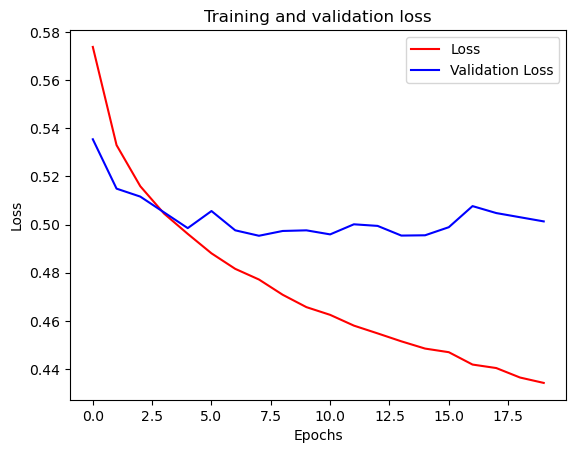

In [96]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [*range(20)]

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

Accuracy Check

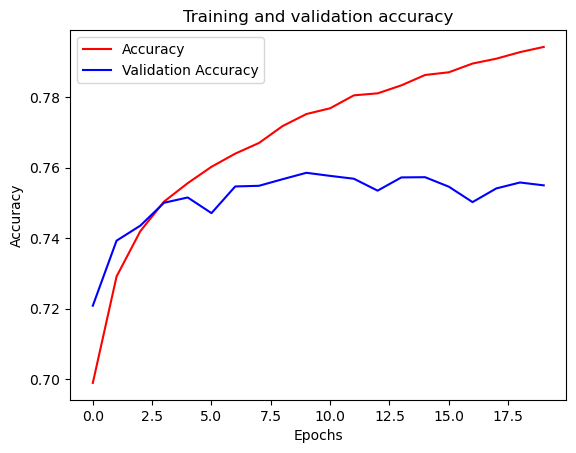

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()


A more rigorous way of setting the passing threshold of this assignment is to use the slope of your val_loss curve.

To pass this assignment the slope of your val_loss curve should be 0.0005 at maximum.

In [98]:
# Test the slope of your val_loss curve
slope, *_ = linregress(epochs, val_loss)
print(f"The slope of your validation loss curve is {slope:.5f}")

The slope of your validation loss curve is -0.00075


In [ ]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)